In [1]:
from libs import *
from model import *
import json

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


# Test data processing

In [3]:
matches = pd.read_csv("perf_results.csv")
M = matches['match_id'].unique()

In [4]:
A = matches[['match_id','point_no','Alpha 1', 'Alpha 2']].loc[(matches['match_id'] == M[20])]

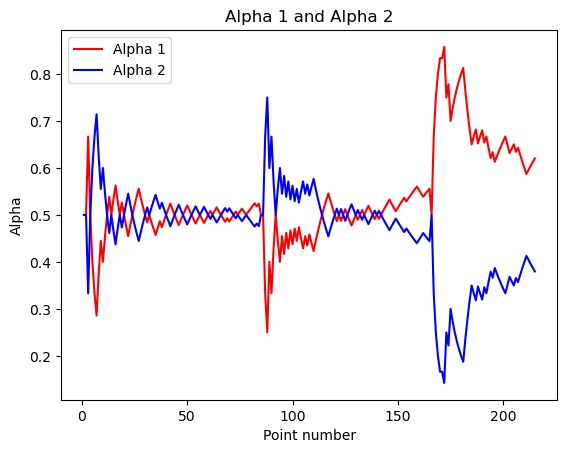

In [5]:
# Plot the data
import matplotlib.pyplot as plt
x = A['point_no'] 
y1 = A['Alpha 1']
y2 = A['Alpha 2']
plt.plot(x, y1, color = 'red', label='Alpha 1')
plt.plot(x, y2, color = 'blue', label='Alpha 2')
plt.xlabel('Point number')
plt.ylabel('Alpha')
plt.title('Alpha 1 and Alpha 2')
plt.legend()

In [6]:
np.random.seed(0)
np.random.shuffle(M)
train_matches = M[:int(0.9*len(M))]
val_matches = M[int(0.9*len(M)):]

In [7]:
matchs = val_matches
lb = pd.read_csv("perf_results.csv")
lb = lb[lb['match_id'].isin(matchs)]

row = lb.iloc[1]
id, point_no = row['match_id'], row['point_no']
id, point_no

point_no = f'point_{point_no}'
with open(f"data/{id}.json", "r") as file:
    data = json.load(file)


In [8]:
np.array(list(data[point_no].values())).shape

(81, 2)

In [9]:
A = np.array(list(data[point_no].values())).T
result = np.zeros((400,81))
result[:A.shape[0],:A.shape[1]] = A

In [10]:
# for match_id in M:
#     df = matches.loc[(matches['match_id'] == match_id) ,:]
#     features = df.columns[4:]
    
#     dict = {}
#     for current_point in range(1, len(df) + 1):
#     # Filter data for the current point_no
#         current_data = df[df['point_no'] <= current_point]
        
#         dict[f'point_{current_point}'] = {}
        
#         for feature in features:
#             dict[f'point_{current_point}'][feature] = list(current_data[feature])
    
#     file_path = f"data/{match_id}.json"

#     with open(file_path, "w") as file:
#         json.dump(dict, file)
    
    

# Dataset

In [11]:
# Create dataset object for each point in match
class Tennis_Dataset(Dataset):
    def __init__(self, phase,  path_db, path_lb, matchs):
        super(Tennis_Dataset, self).__init__()
        self.phase = phase
        
        lb = pd.read_csv(path_lb)
        lb = lb[lb['match_id'].isin(matchs)]
        
        self.path_db = path_db
        self.result = lb
        self.output = ['Alpha 1', 'Alpha 2']
        
        self.json_data = {}
        for match_id in matchs:
            json_file_path = os.path.join(self.path_db, f"{match_id}.json")
            with open(json_file_path, "r") as file:
                self.json_data[match_id] = json.load(file)
        
    def __len__(self):
        return len(self.result)
    
    def __getitem__(self, idx):
        row = self.result.iloc[idx]
        id, point_no = row['match_id'], row['point_no']
        point_no = f'point_{point_no}'
        
        data = self.json_data[id]
        point_data = data[point_no]
        
        A = np.array(list(data[point_no].values())).T
        
        result = np.zeros((400,81))
        result[:A.shape[0],:A.shape[1]] = A
        
        labels = row[self.output].to_numpy(dtype=np.float32)
        
        return torch.from_numpy(result.transpose()).float(), torch.from_numpy(labels).float()
    
    
    

In [12]:
train_dataset = Tennis_Dataset('train', 'data', "perf_results.csv", train_matches)
val_dataset = Tennis_Dataset('val', 'data', "perf_results.csv", val_matches)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size= 3, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size= 3, shuffle=False)

In [14]:
# Calculate the lengths of the train and validation datasets
train_dataset_length = len(train_dataset)
val_dataset_length = len(val_dataset)

# Calculate the percentage of validation dataset
percent_validation = (val_dataset_length / (train_dataset_length + val_dataset_length)) * 100

# Print the percentage of validation dataset
print(f"The percentage of validation dataset is: {percent_validation:.2f}%")


The percentage of validation dataset is: 13.07%


# Model for training

In [15]:
from model import Regression_sequential_data, resnet_1d

In [16]:
from utlis import Train, Test

## Resnet

In [17]:
from model import resnet_1d

input_size = (81, 400)
model_Resnet = resnet_1d.ResNet18(num_classes=2, channels=81).to(device)

In [ ]:
learning_rate = 5e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_Resnet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=40) 

In [19]:
Test.test_model(train_dataloader,model_Resnet, criterion, device)

Test loss: 0.7129418534557156


In [20]:
for epoch in range(10):
    Train.train_model(train_dataloader, model_Resnet, epoch, criterion, optimizer, device)
    Test.test_model(val_dataloader, model_Resnet, criterion, device)

Training epoch 0:


100%|██████████| 2111/2111 [00:44<00:00, 47.30it/s]


Train loss: 0.7112219713977703
Test loss: 0.7027597449860483
Training epoch 1:


100%|██████████| 2111/2111 [00:43<00:00, 48.52it/s]


Train loss: 0.6980688457012403
Test loss: 4.734693506791157
Training epoch 2:


100%|██████████| 2111/2111 [00:43<00:00, 48.34it/s]


Train loss: 0.6952285680484004
Test loss: 0.706860325433923
Training epoch 3:


100%|██████████| 2111/2111 [00:44<00:00, 47.95it/s]


Train loss: 0.6940070156913298
Test loss: 1.0010178543674122
Training epoch 4:


100%|██████████| 2111/2111 [00:42<00:00, 49.80it/s]


Train loss: 0.6935805029803573
Test loss: 0.7790584987814322
Training epoch 5:


100%|██████████| 2111/2111 [00:43<00:00, 48.61it/s]


Train loss: 0.6933265744312743
Test loss: 0.6935855004022706
Training epoch 6:


100%|██████████| 2111/2111 [00:42<00:00, 49.10it/s]


Train loss: 0.6932954158561595
Test loss: 0.69503689974359
Training epoch 7:


100%|██████████| 2111/2111 [00:42<00:00, 49.81it/s]


Train loss: 0.6934074462165996
Test loss: 0.6945827743917141
Training epoch 8:


100%|██████████| 2111/2111 [00:42<00:00, 49.63it/s]


Train loss: 0.6932097862874766
Test loss: 0.6938702584062733
Training epoch 9:


100%|██████████| 2111/2111 [00:43<00:00, 49.01it/s]


Train loss: 0.6931270639064018
Test loss: 0.6954866503394624


In [22]:
torch.save(model_Resnet.state_dict(), 'result/Resnet.plt')